# Semi-Supervised VAE Project
## By VAEGen

## Setup

### Import libraries

In [1]:
import os
import time
import torch
import argparse
# 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict

# Torch
from torch.utils.data import DataLoader
import torch.nn.functional as F

# Torchvision
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.datasets import FashionMNIST

### Meta parameters

In [2]:
batch_size=32*8*2
epochs=10
learning_rate=1e-3
latent_dim = 32
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#print layers, used for debugging
NNprint_ = False

### Import MNIST Dataset

In [3]:
# train = MNIST(
#     root='data', train=True, transform=transforms.ToTensor(),
#     download=True)
# test= MNIST(
#     root='data', train=True, transform=transforms.ToTensor(),
#     download=False)

### Import FashionMNIST Dataset

In [4]:
train = FashionMNIST(
    root='data', train=True, transform=transforms.ToTensor(),
    download=True)
test= FashionMNIST(
    root='data', train=True, transform=transforms.ToTensor(),
    download=False)

### Configure Loaders

In [5]:
train_loader = torch.utils.data.DataLoader(
  train,
  batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  test,
  batch_size=batch_size, shuffle=True)

### Plot examples

In [42]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
def plot_examples(model=None,sample=False):
    data = None
    if (model==None):
        batch_idx, (data, example_targets) = next(examples)
    else:
        batch_idx, (data, example_targets) = next(examples)
        if sample:
            zeros=torch.zeros(10,1024)
            samples= torch.cat((torch.rand(32,1024),zeros)).T
            data = model.sample(samples.to(device))
        else:
            data = model(data.to(device),example_targets)[0]
        
    fig = plt.figure()
    fig.set_figheight(15)
    fig.set_figwidth(15)
    for i in range(64):
        plt.subplot(8,8,i+1)
        plt.tight_layout()
        if model:
            plt.imshow(data[i][0].cpu().data, cmap='gray', interpolation='none')
        else:
            plt.imshow(data[i][0], cmap='gray', interpolation='none')
    #     plt.title("Ground Truth: {}".format(example_targets[i]))
        plt.xticks([])
        plt.yticks([])
        

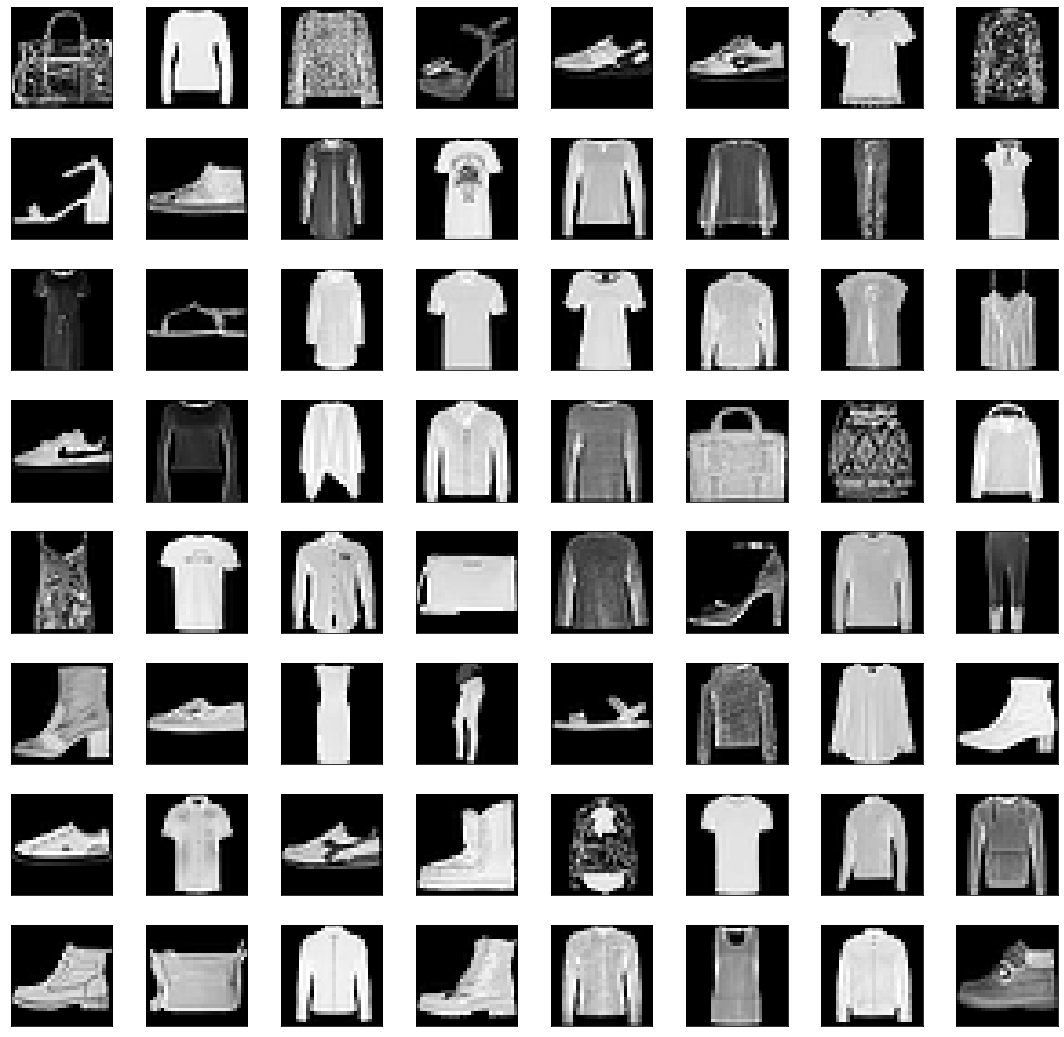

In [43]:
plot_examples()

### Torch auxiliary modules

In [15]:
class Flatten(torch.nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)
    
class UnFlatten(torch.nn.Module):
    def forward(self, input, size=1024):
        return input.view(input.size(0), size, 1, 1)

# Debugging module 
class NNprint(torch.nn.Module):
    def forward(self, input):
        if NNprint_==True:
            print(input.shape)
        return input  

## VAE

In [16]:
#VAE implementation

## CVAE

In [17]:

class CVAE(torch.nn.Module):
    def __init__(self, image_channels=1, h_dim=1024, z_dim=32,num_labels=10):
        super(CVAE, self).__init__()
        self.encoder = torch.nn.Sequential(
            NNprint(),
            torch.nn.Conv2d(image_channels, 32, kernel_size=3, stride=2),
            NNprint(),
            torch.nn.LeakyReLU(),
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=2),
            NNprint(),
            torch.nn.LeakyReLU(),
            torch.nn.Conv2d(64, 128, kernel_size=3, stride=1),
            NNprint(),
            torch.nn.LeakyReLU(),
            torch.nn.Conv2d(128, 256, kernel_size=3, stride=1),
            NNprint(),
            torch.nn.LeakyReLU(),
            Flatten(),
            
            
            NNprint(),
            
        )
        self.h_dim=h_dim
        self.num_labels=num_labels
        self.fc1 = torch.nn.Linear(h_dim, z_dim)
        self.fc2 = torch.nn.Linear(h_dim, z_dim)
        self.fc3 = torch.nn.Linear(z_dim+num_labels, h_dim)
        
        self.decoder = torch.nn.Sequential(
            NNprint(),
            UnFlatten(),
            NNprint(),
            torch.nn.ConvTranspose2d(h_dim, 128, kernel_size=4, stride=2),
            torch.nn.LeakyReLU(),
            NNprint(),
            torch.nn.ConvTranspose2d(128, 64, kernel_size=5, stride=2),
            torch.nn.LeakyReLU(),
            NNprint(),
            torch.nn.ConvTranspose2d(64, 32, kernel_size=4,padding=0, stride=2),
            torch.nn.LeakyReLU(),
            NNprint(),
            torch.nn.ConvTranspose2d(32, image_channels, kernel_size=5, stride=1),
            torch.nn.Sigmoid(),
            NNprint(),
        )
        
    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        # return torch.normal(mu, std)
        esp = torch.randn(*mu.size())
        z = mu.to(device) + std.to(device) * esp.to(device)
        return z
    
    def bottleneck(self, h,labels):
        mu, logvar = self.fc1(h), self.fc2(h)
        z = self.reparameterize(mu, logvar)
        z=torch.cat((z,torch.nn.functional.one_hot(labels,self.num_labels).type(torch.float).to(device)),1)
        return z, mu, logvar

    def encode(self, x,labels):
        h = self.encoder(x)
#         h=torch.cat((h,labels.float().reshape(labels.size(0),1).to(device)),dim=1)
        z, mu, logvar = self.bottleneck(h,labels)
        return z, mu, logvar

    def decode(self, z):
        z = self.fc3(z)
        z = self.decoder(z)
        return z

    def forward(self, x,labels):
        z, mu, logvar = self.encode(x,labels)
#         print('z',z.shape)
        z = self.decode(z)
        return z, mu, logvar
    
    def sample(self,z):
        return self.decode(z)

In [20]:
image_channels = example_data.size(1)
image_channels

1

In [21]:
model = CVAE(image_channels=image_channels,h_dim=1024,z_dim=latent_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [22]:
def loss_fn(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.to(device), size_average=False,reduction='sum' )
    # BCE = F.mse_loss(recon_x, x, size_average=False)

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD, BCE, KLD

In [23]:
%%time
for epoch in range(epochs):
    for idx, (images, labels) in enumerate(train_loader):
#         print(idx)
        recon_images, mu, logvar = model(images.to(device),labels)
        loss, bce, kld = loss_fn(recon_images, images, mu, logvar)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if idx%500==0:
            to_print = "Epoch[{}/{}] Loss: {:.3f} {:.3f} {:.3f}".format(epoch+1, 
                                        epochs, loss.data.cpu().numpy().tolist()/batch_size, bce.data.cpu().numpy().tolist()/batch_size, kld.data.cpu().numpy().tolist()/batch_size)
            print(to_print)
torch.save(model.state_dict(), 'cvae.torch')


/home/benjamin/.local/lib/python3.8/site-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch[1/10] Loss: 559.534 559.534 0.000
Epoch[2/10] Loss: 250.722 250.710 0.012
Epoch[3/10] Loss: 240.607 240.592 0.015
Epoch[4/10] Loss: 232.474 232.457 0.017
Epoch[5/10] Loss: 230.616 230.599 0.017
Epoch[6/10] Loss: 216.005 215.988 0.017
Epoch[7/10] Loss: 221.831 221.816 0.016
Epoch[8/10] Loss: 216.012 215.996 0.016
Epoch[9/10] Loss: 214.767 214.751 0.016
Epoch[10/10] Loss: 213.271 213.255 0.016
CPU times: user 6min 55s, sys: 176 ms, total: 6min 55s
Wall time: 6min 55s


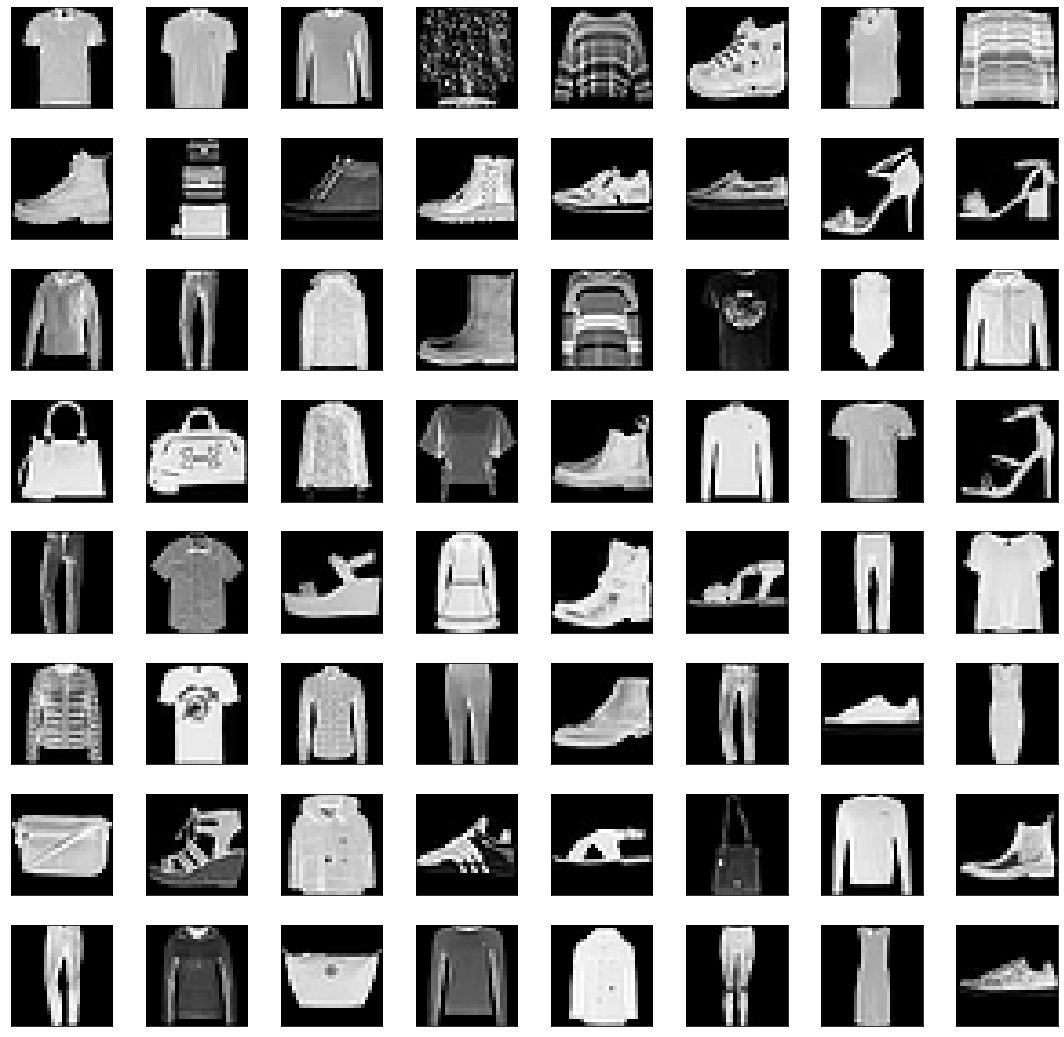

In [44]:
plot_examples()

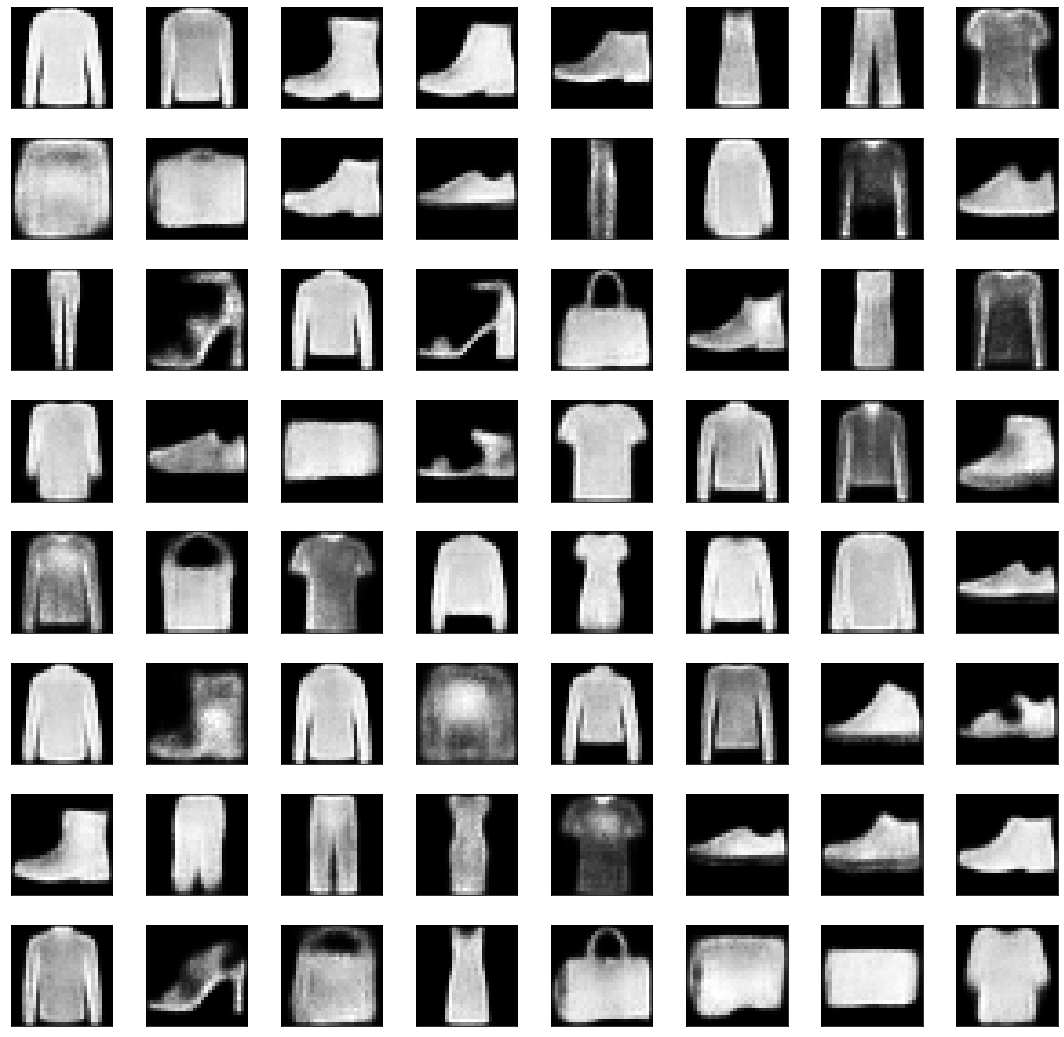

In [45]:
#Reconstructions
plot_examples(model)


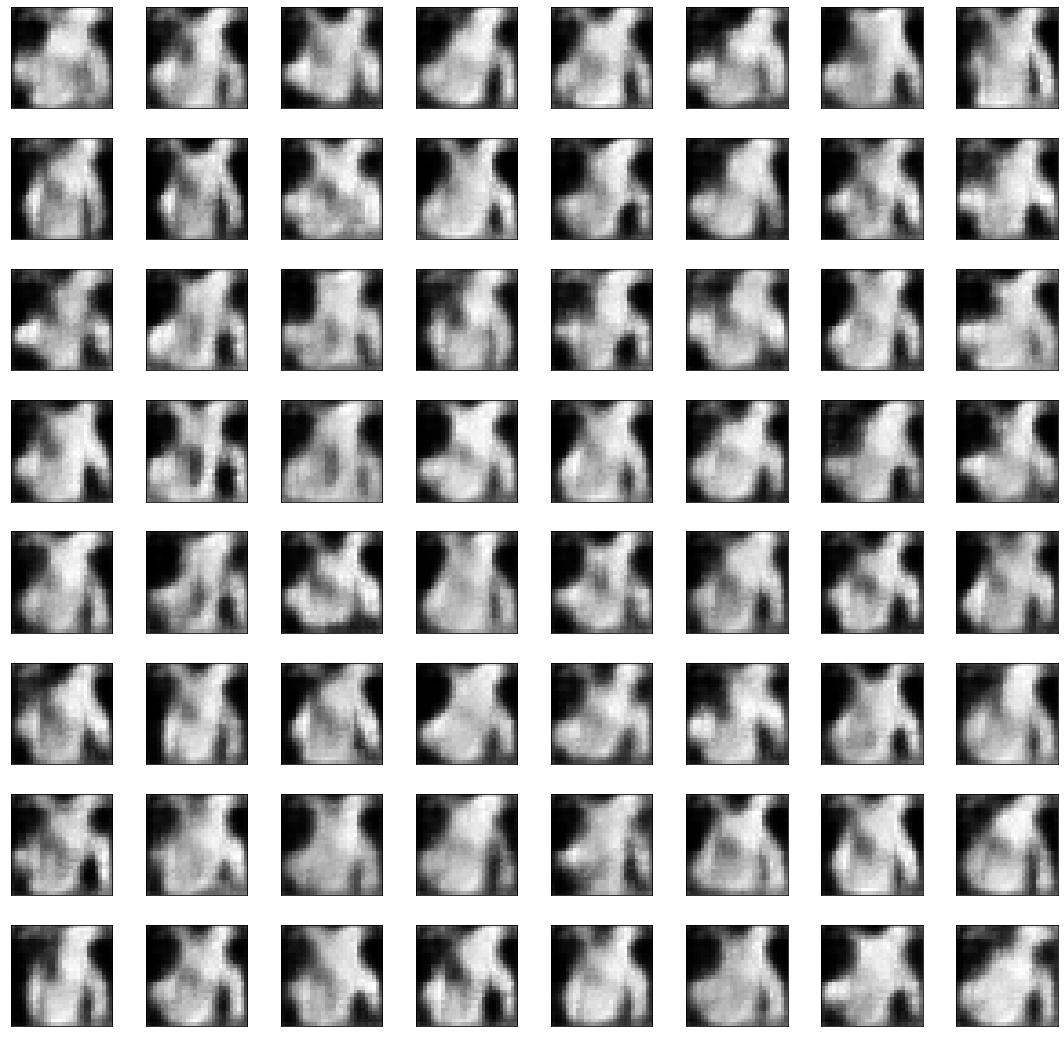

In [46]:
# Sample latent space
plot_examples(model,sample=True)